In [1]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import ttest_1samp

#plotting stuff
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Myriad Pro"

# import local functions
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from functions.author_fns import Author, compare_nets

%matplotlib inline

## Load data

In [2]:
method = 'florida'
node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
g = igraph.load('../data/florida_coa_graph',format='pickle')

In [3]:
nAuth = 500
nAuthSt = 200 # how many authors we start with
nMeetings = 200
learn_thr = .1
c = 3
diam = 3
net_size_o = 500
bib_length = 70
woman_perc_i = .3
meet_method = 'soc'
woman_perc_f = sum([x['gender'] == 'woman' for x in node_2_gender.values()])/len(node_2_gender)
colors = ['#d97d5b', '#4a3b90', '#5295d0', '#fabc50']

In [4]:
# original parameters

net_w = (.55,.1)
net_m = (.4,.1)
walk_w = (.55,.05)
walk_m = (.40,.05)
if meet_method == 'soc':
    meet_w = (0.06,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)
forget_w = (.15,.02)
forget_m = (.15,.02)

In [5]:
# function definition

# group meeting function
def group_meet(n, auths, idx):
    curr_meets = {}
    for j in range(int(n)):        
        # pick author for meeting
        k = np.random.choice(idx)
        
        # check if at least one will meet
        [m12,m21] = compare_nets(auths[j], auths[k], meet_method)
        a1_size = auths[j].network.vcount()
        a2_size = auths[k].network.vcount()
        if any([m12,m21]):
            # if yes, update the network
            if m12:
                bib = auths[k].get_cites(bib_length)
                auths[j].update_network(bib, auths[k].network, learn_thr)
                # forget
                auths[j].forget(n=auths[j].network.vcount()-a1_size)
            if m21:
                bib = auths[j].get_cites(bib_length)
                auths[k].update_network(bib, auths[j].network, learn_thr)
                # forget
                auths[k].forget(n=auths[k].network.vcount()-a2_size)
        # log information
        # update meets
        curr_meets[j] = {'gender1': auths[j].gender, 'gender2':auths[k].gender, 'meet12':m12, 'meet21':m21}
    
    curr_auths = [auths[x] for x in idx]
    w_index = [a.gender == 'W' for a in curr_auths]
    m_index = [not(x) for x in w_index]
    # get network size
    net_size = (np.mean([len(a.memory) for a in curr_auths]),np.std([len(a.memory) for a in curr_auths]))
    # update cites
    bibs = [a.get_cites(bib_length) for a in curr_auths]
    bibs_w = [b for i,b in enumerate(bibs) if w_index[i]]
    bibs_m = [b for i,b in enumerate(bibs) if m_index[i]]
    
    return curr_meets, net_size, bibs, bibs_w, bibs_m

# inside of parameter sweeps for paralelizing
def param_sweep(o_auths, param, p, param_std_dist=None, ind=None):
    authors = o_auths.copy()
    for i,a in enumerate(authors):
        if param == 'walk':
            if a.gender == 'M':
                a.walk_bias = np.random.normal(loc=p,scale=walk_m[1],size=1)[0]
        elif param == 'meet':
            if a.gender == 'M':
                a.meet_bias = np.random.normal(loc=p,scale=param_std_dist[ind],size=1)[0]

    # run simulation
    data = []
    for i,b in tqdm(enumerate(range(nMeetings))):
        #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
        tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])
        data.append(tmp)
        del tmp

    # intialize final data structs
    meets = {}; # keep track of when meetings were successful
    net_size = []
    bibs = {}
    bibs_w = {}
    bibs_m = {}
    cite_perc = []
    percs = [x['woman_perc'] for x in sim_params.values()]

    # reformat data
    cite_data = pd.DataFrame(columns=['perc','gen','time'])
    prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
    for i,d in enumerate(data):    
        curr_meets, ns, bs, bws, bms = d
        curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
        meets.update(curr_meets)
        net_size.append(ns)
        bibs[i] = bs
        bibs_w[i] = bws
        bibs_m[i] = bms
        
    # static data
    static_perc = np.empty((nMeetings,len(bibs[nMeetings-1])))
    static_perc[:] = np.NaN
    static_perc_w = np.empty((nMeetings,len(bibs_w[nMeetings-1])))
    static_perc_w[:] = np.NaN
    static_perc_m = np.empty((nMeetings,len(bibs_m[nMeetings-1])))
    static_perc_m[:] = np.NaN
    for i,b in enumerate(bibs_w.values()):
        # get all w authors citations at this time point
        for j,p in enumerate(b):
            # add to list
            static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

    for i,b in enumerate(bibs_m.values()):
        # get all m authors citations at this time point
        for j,p in enumerate(b):
            # add to list
            static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
    statics.append({'wmu':np.nanmean(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1)),
                   'wstd':np.nanstd(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1))/np.sqrt(len(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1))),
                   'mmu':np.nanmean(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1)),
                   'mstd':np.nanstd(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1))/np.sqrt(len(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1)))})
    
    # time varying data
    cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
    for i,b in bibs.items():
        curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
        tmp_data = pd.DataFrame({'perc': curr_perc, 
                                 'gen':['w']*len(curr_perc),
                                 'citer':['all']*len(curr_perc),
                                 'time':[i]*len(curr_perc)})
        cite_data = pd.concat([cite_data,tmp_data])

    for i,b in bibs_w.items():
        curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
        curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    

        # womens citation by gender
        gen = ['w']*len(curr_perc_w)
        gen.extend(['m']*len(curr_perc_m))
        tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                                  'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                                  'gen':gen,
                                  'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
        cite_data = pd.concat([cite_data,tmp_data])

    for i,b in bibs_m.items():
        curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
        curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    

        # mens citation by gender
        gen = ['w']*len(curr_perc_w)
        gen.extend(['m']*len(curr_perc_m))
        tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                                 'gen':gen, 
                                 'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                                 'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
        cite_data = pd.concat([cite_data,tmp_data])
    X = sm.add_constant(range(nMeetings))
    yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
    modw = sm.OLS(yw, X)
    resw = modw.fit()
    ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
    modm = sm.OLS(ym, X)
    resm = modm.fit()
    slopes.append({'wslope':resw.params[1],
                 'wci':resw.conf_int(0.05)[1],
                 'mslope':resm.params[1],
                 'mci':resm.conf_int(0.05)[1]})
    return slopes, statics
    

### Walk Bias - random walks

In [6]:
net_w = (.55,.1)
net_m = (.4,.1)
walk_w = (.55,.05)
walk_m = (.50,.05)
if meet_method == 'soc':
    meet_w = (0.06,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)
forget_w = (5.,.02)
forget_m = (5.,.02)

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


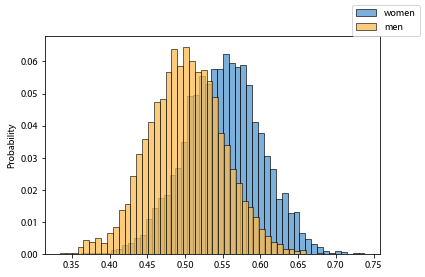

In [7]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/beta_int1.pdf')

In [8]:
# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
        forget = np.random.normal(loc=forget_m[0],scale=forget_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
        forget = np.random.normal(loc=forget_w[0],scale=forget_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,forget,gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nMeetings))
new_w_perc = ((woman_perc_f*nAuth) - (woman_perc_i*nAuthSt))/(nAuth-nAuthSt) # with probability should the added authors be women?
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nMeetings):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        for j in range(int(dn)):
            f = np.random.rand(1,1)
            a = []
            if f >= new_w_perc:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

200it [09:50,  2.95s/it]


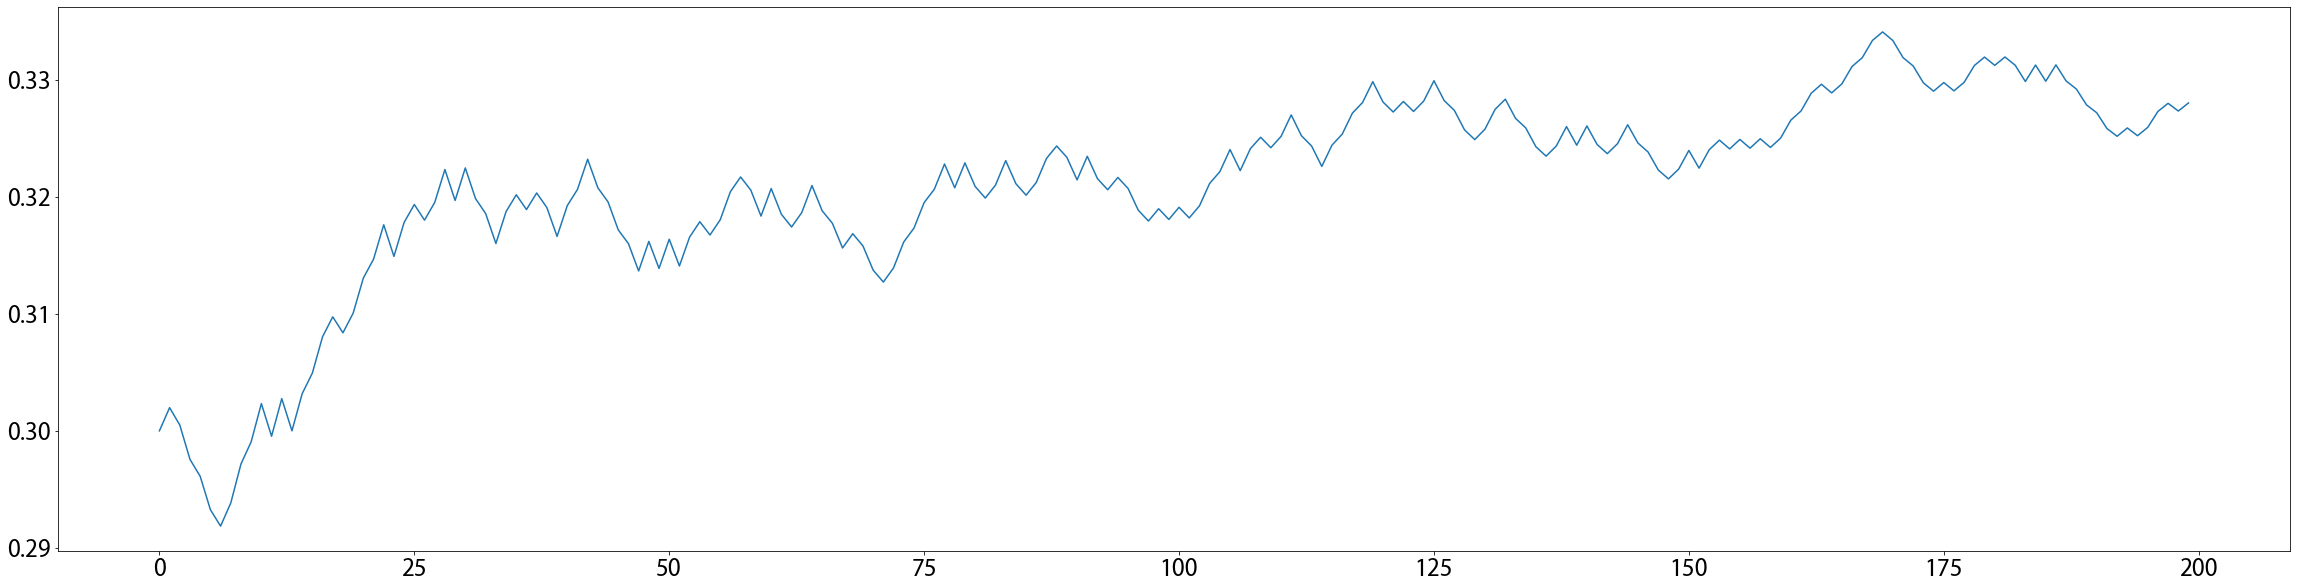

In [9]:
# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in tqdm(enumerate(range(nMeetings))):
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])
    data.append(tmp)
    del tmp

In [10]:
# intialize final data structs
meets = {}; # keep track of when meetings were successful
citation_perc = []
citation_perc_w = []
citation_perc_m = []
net_size = []

# reformat data
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms

#### Plots

<AxesSubplot:>

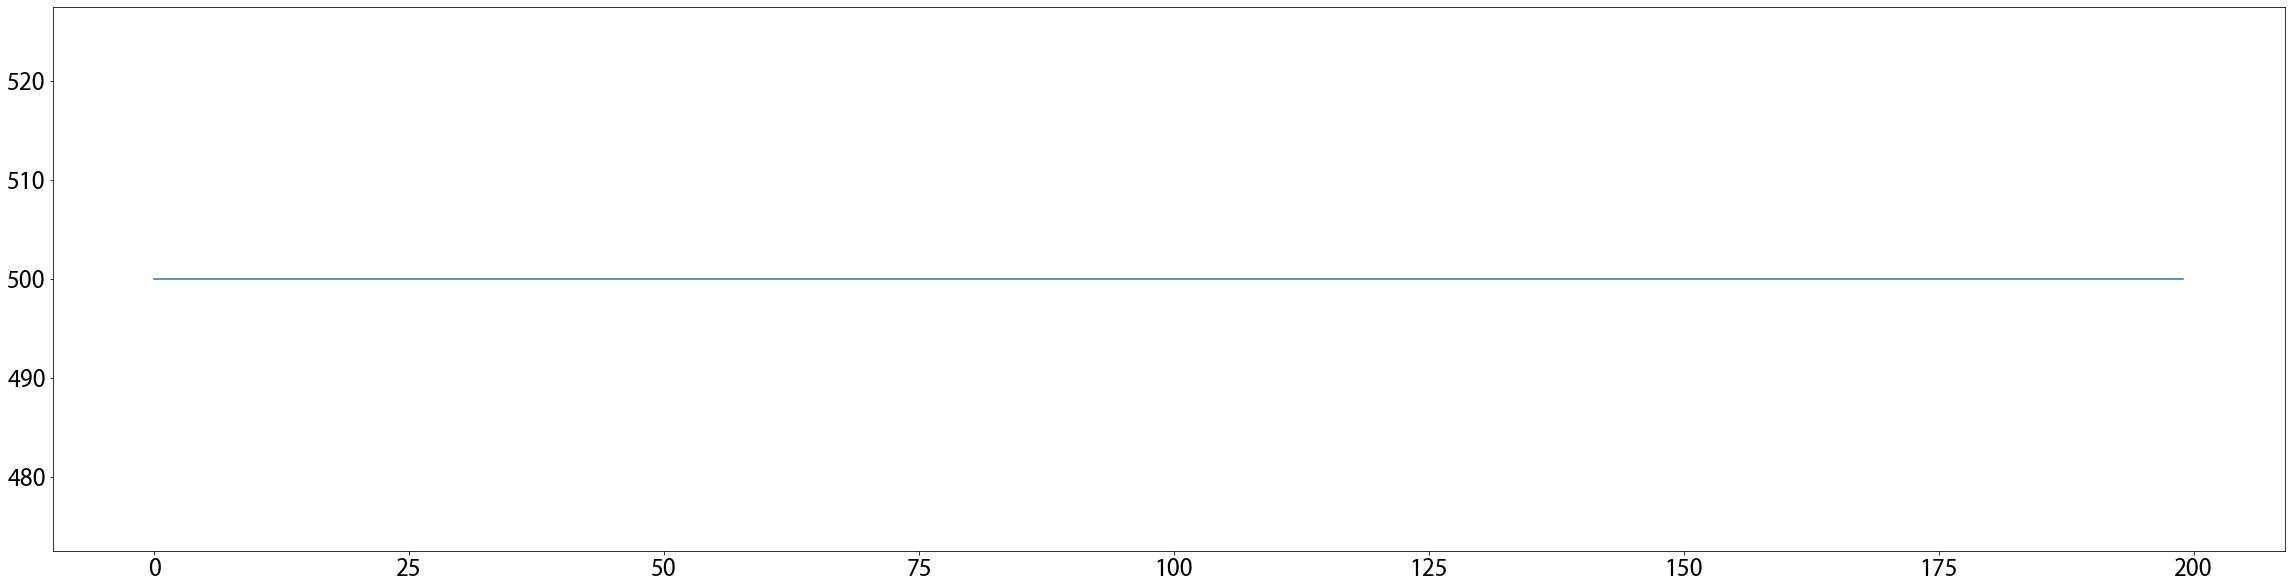

In [11]:
# network size
plt.figure(figsize=(40,10))
sns.lineplot(data=[x[0] for x in net_size])

Text(0.5, 1.0, 'Different Gender Meetings')

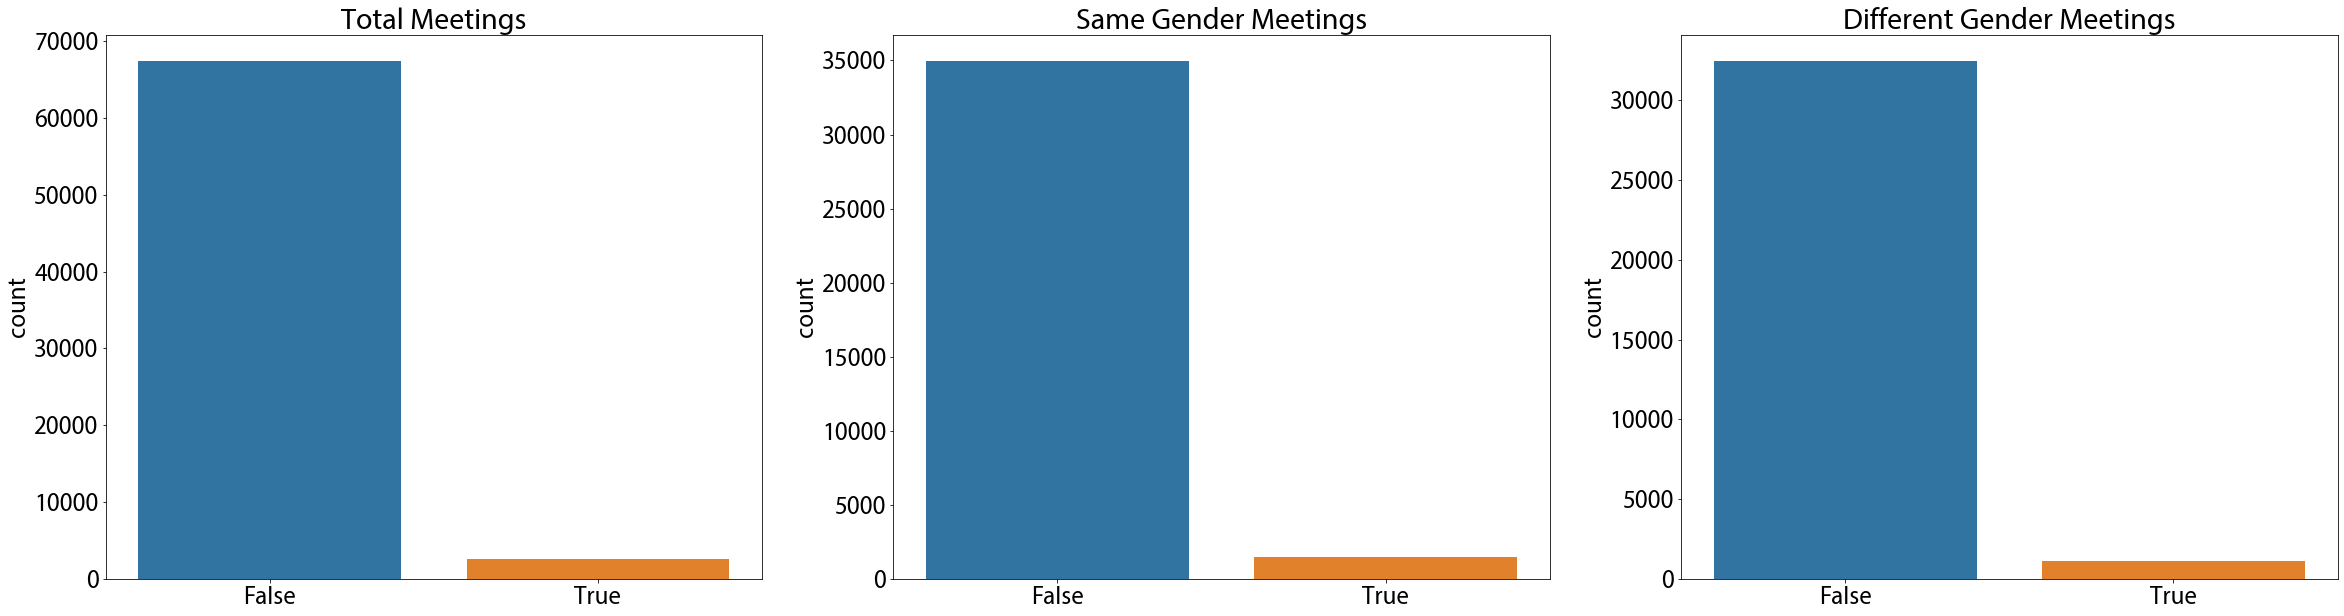

In [12]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


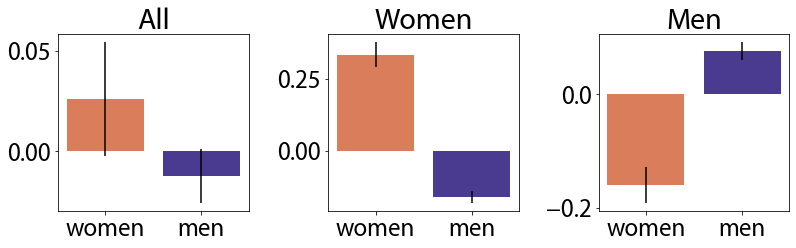

In [13]:
# static plot
static_perc = np.empty((nMeetings,len(bibs[nMeetings-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nMeetings,len(bibs_w[nMeetings-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nMeetings,len(bibs_m[nMeetings-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.bar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])], color=colors)
plt.errorbar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])],
             [np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nMeetings-1])), 
                          np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nMeetings-1]))], fmt='none', color='k')
plt.title('All')
plt.subplot(132)
plt.bar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_w.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])], color=colors)
plt.errorbar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_w.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])],
             [np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs_w[nMeetings-1])), 
                          np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs_w[nMeetings-1]))], fmt='none', color='k')
plt.title('Women')
plt.subplot(133)
plt.bar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_m.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])], color=colors)
plt.errorbar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_m.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])],
             [np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs_m[nMeetings-1])), 
                          np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs_m[nMeetings-1]))], fmt='none', color='k')
plt.title('Men')
plt.tight_layout()
plt.savefig('../data/img/static_cites_int1.pdf')

In [14]:
# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

All citers (w): 1.6132474123789058, 0.10748333311265491
All citers (m): -1.594080867598744, 0.11171170766600338
W citers (w): 13.626069825588848, 1.0381481468978263e-28
W citers (m): -13.626617228497892, 1.0345154438407876e-28
M citers (w): -9.08717623614597, 4.424024513883112e-17
M citers (m): 9.151296922308637, 2.8593899653917187e-17


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


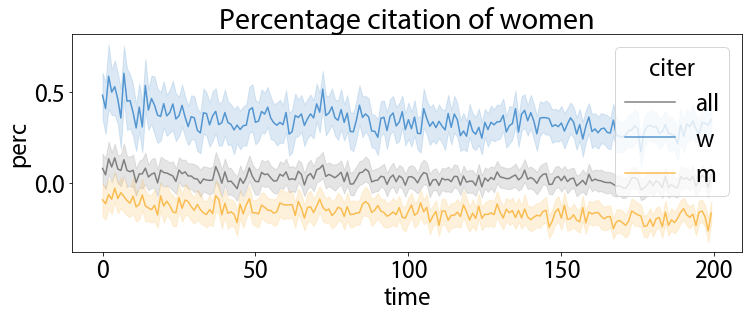

In [15]:
cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig('../data/img/all_cite_w_int1.pdf')

In [16]:
# stats
X = sm.add_constant(range(nMeetings))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

All citers: -0.0002715063367018549, 1.0094892743333558e-14
W citers: -0.0006320621011566584, 1.5215278491067418e-19
M citers: -0.0004793926234333063, 7.019613861415626e-28


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


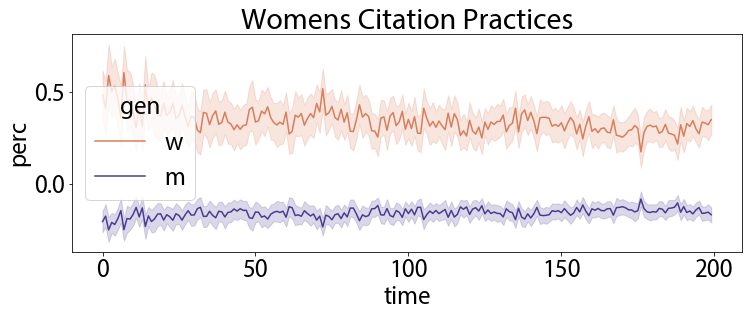

In [17]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'w'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Womens Citation Practices')
plt.savefig('../data/img/w_cite_w_int1.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


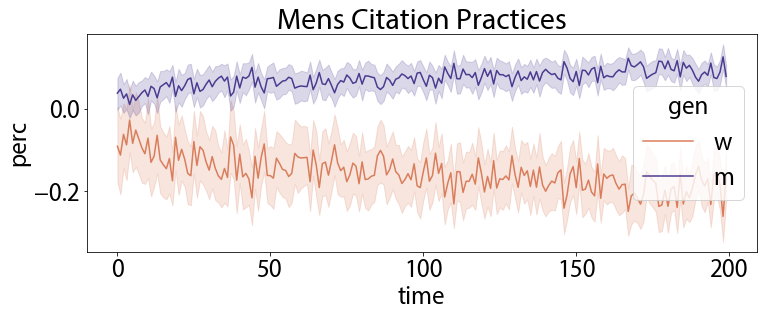

In [18]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'm'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Mens Citation Practices')
plt.savefig('../data/img/m_cite_w_int1.pdf')

### Walk Bias - bias towards women

In [19]:
net_w = (.55,.1)
net_m = (.4,.1)
walk_w = (.55,.05)
walk_m = (.60,.05)
if meet_method == 'soc':
    meet_w = (0.06,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)
forget_w = (2.,.02)
forget_m = (2.,.02)


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


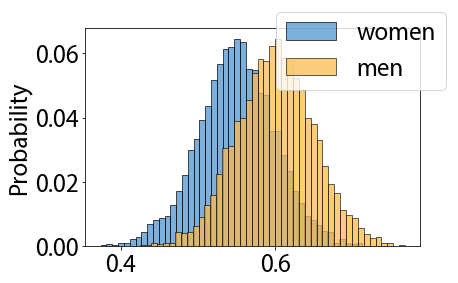

In [20]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/beta_int2.pdf')

In [21]:
# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
        forget = np.random.normal(loc=forget_m[0],scale=forget_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
        forget = np.random.normal(loc=forget_w[0],scale=forget_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,forget,gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nMeetings))
new_w_perc = ((woman_perc_f*nAuth) - (woman_perc_i*nAuthSt))/(nAuth-nAuthSt) # with probability should the added authors be women?
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nMeetings):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        for j in range(int(dn)):
            f = np.random.rand(1,1)
            a = []
            if f >= new_w_perc:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

200it [09:31,  2.86s/it]


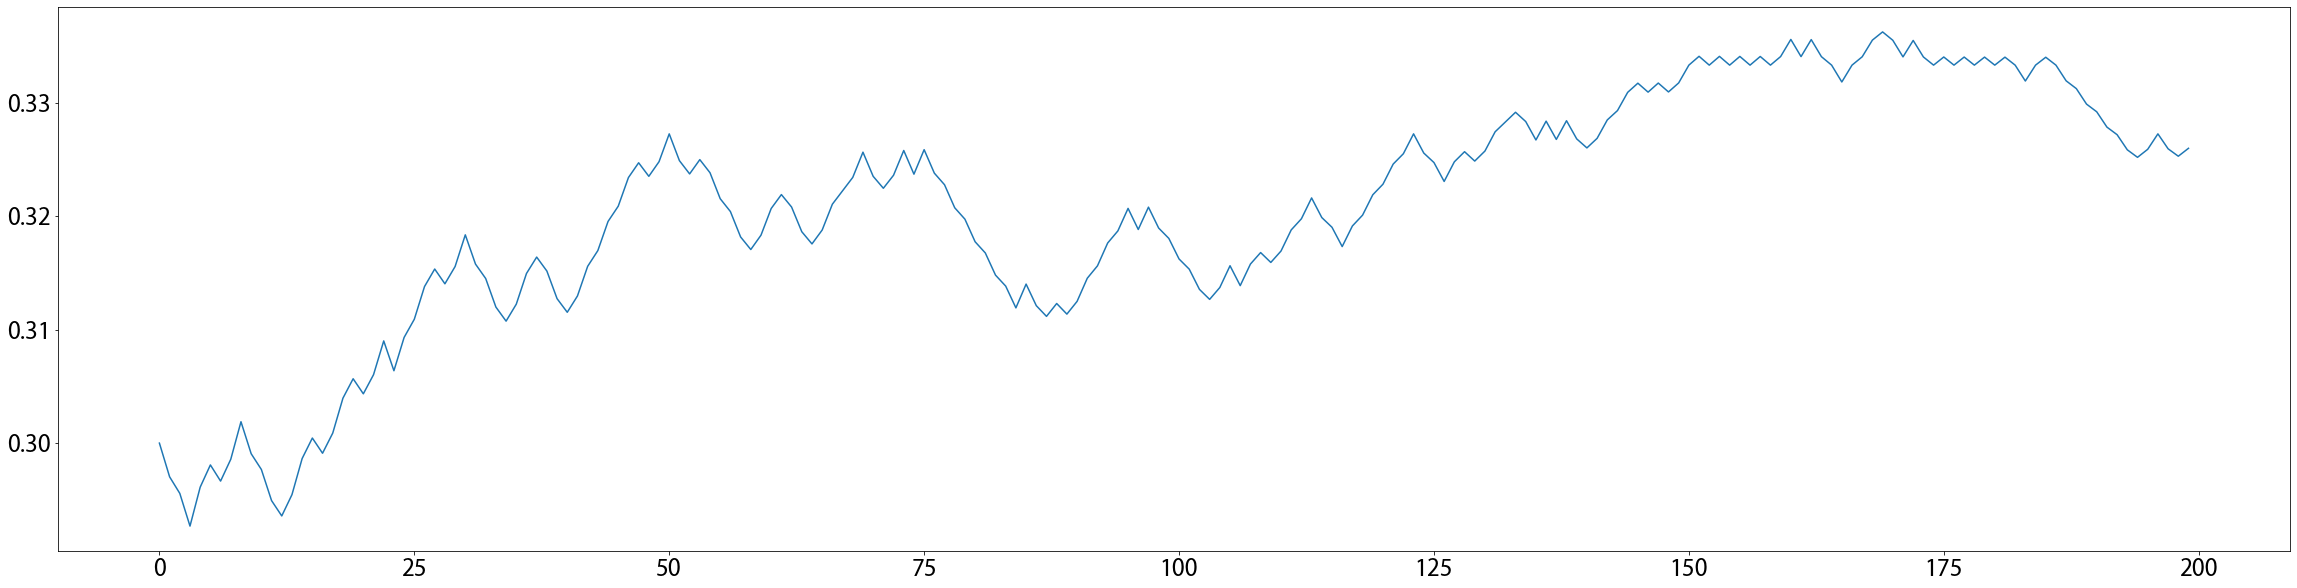

In [22]:
# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in tqdm(enumerate(range(nMeetings))):
    #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])
    data.append(tmp)
    del tmp

# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms

#### Plots

<AxesSubplot:>

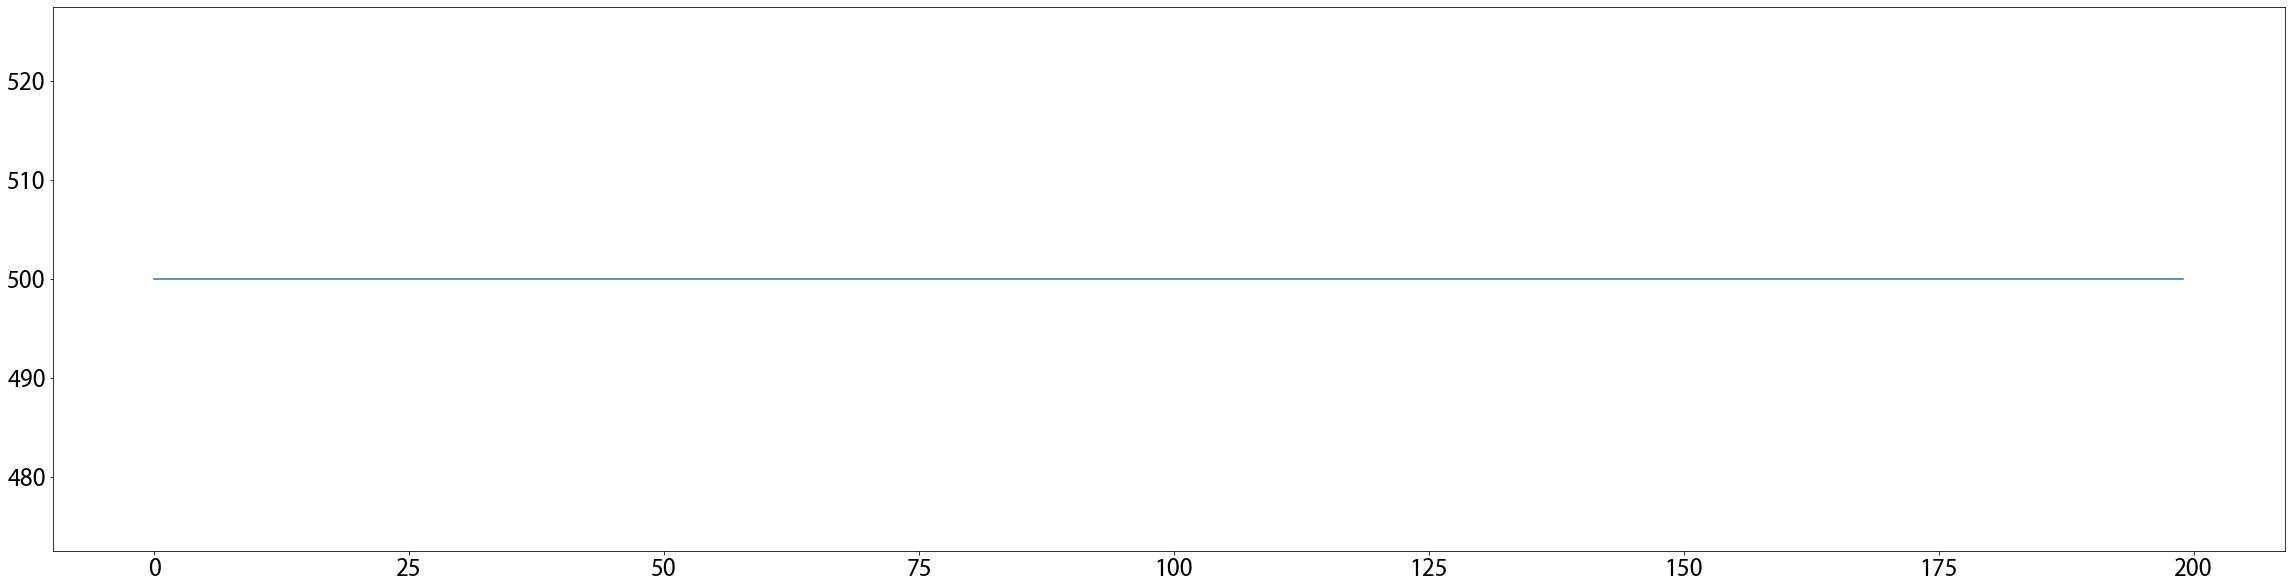

In [23]:
# network size
plt.figure(figsize=(40,10))
sns.lineplot(data=[x[0] for x in net_size])

Text(0.5, 1.0, 'Different Gender Meetings')

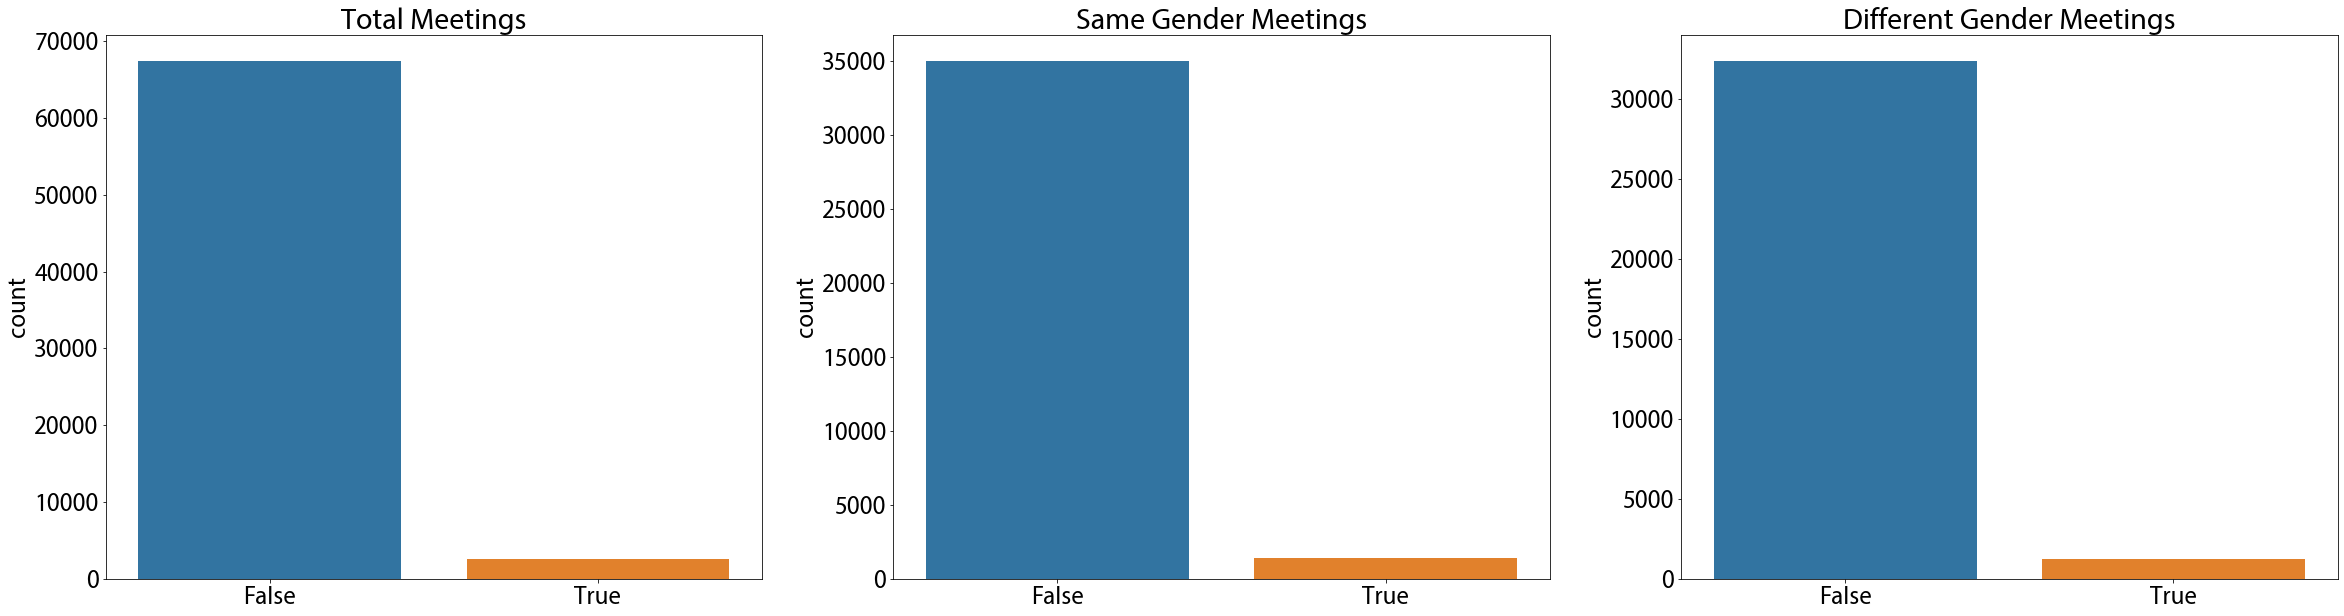

In [24]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


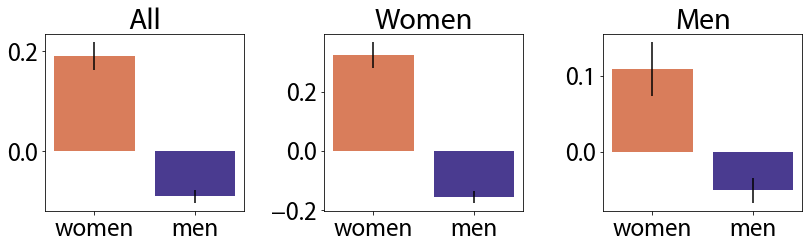

In [25]:
# static plot
static_perc = np.empty((nMeetings,len(bibs[nMeetings-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nMeetings,len(bibs_w[nMeetings-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nMeetings,len(bibs_m[nMeetings-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.bar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])], color=colors)
plt.errorbar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])],
             [np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nMeetings-1])), 
                          np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nMeetings-1]))], fmt='none', color='k')
plt.title('All')
plt.subplot(132)
plt.bar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_w.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])], color=colors)
plt.errorbar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_w.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])],
             [np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs_w[nMeetings-1])), 
                          np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs_w[nMeetings-1]))], fmt='none', color='k')
plt.title('Women')
plt.subplot(133)
plt.bar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_m.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])], color=colors)
plt.errorbar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_m.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])],
             [np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs_m[nMeetings-1])), 
                          np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs_m[nMeetings-1]))], fmt='none', color='k')
plt.title('Men')
plt.tight_layout()
plt.savefig('../data/img/static_cites_int2.pdf')

In [26]:
# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

All citers (w): 11.787686088782502, 1.028434949885225e-27
All citers (m): -11.715775339237448, 1.9345493196521683e-27
W citers (w): 13.417926337661184, 4.404788810643926e-28
W citers (m): -13.382093640947032, 5.538192655325304e-28
M citers (w): 4.946712588469447, 1.4381503910251874e-06
M citers (m): -4.858012479658038, 2.166278203840763e-06


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


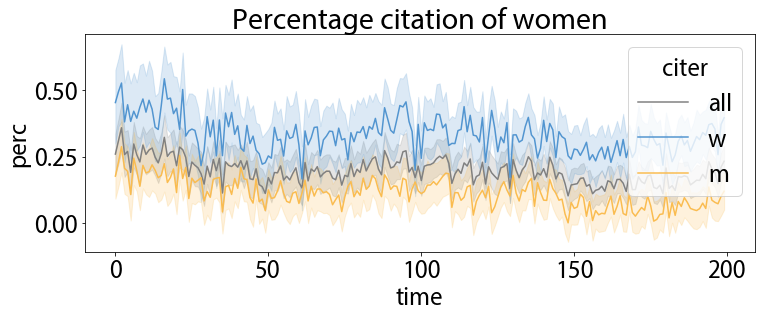

In [27]:
cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig('../data/img/all_cite_w_int2.pdf')

In [28]:
# stats
X = sm.add_constant(range(nMeetings))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

All citers: -0.0004228693686095225, 4.053854942553129e-16
W citers: -0.00047358384392196884, 1.2659918956314595e-09
M citers: -0.0005953228303409259, 5.52618765950803e-25


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


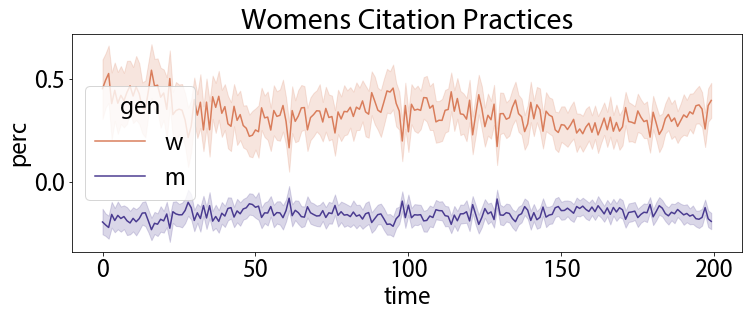

In [29]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'w'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Womens Citation Practices')
plt.savefig('../data/img/w_cite_w_int2.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


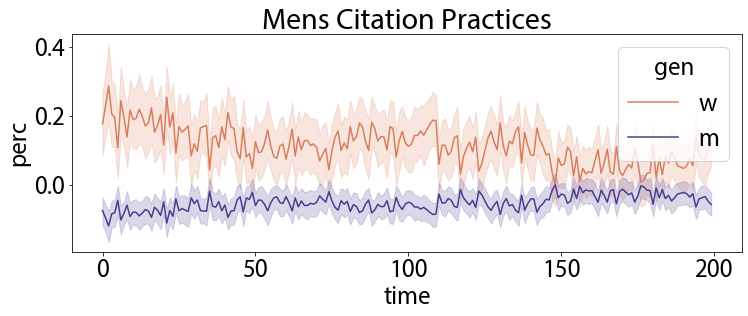

In [30]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'm'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Mens Citation Practices')
plt.savefig('../data/img/m_cite_w_int2.pdf')

#### Parameter sweeps

In [31]:
import cProfile

# parameter range we are interested in
parameter = np.linspace(0.4,0.8,10)
statics = []
slopes = []

# generate authors
authors_orig = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
        forget = np.random.normal(loc=forget_m[0],scale=forget_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
        forget = np.random.normal(loc=forget_w[0],scale=forget_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,forget,gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors_orig.append(a)
    
# simulate meeting parameters
w_index = [a.gender == 'W' for a in authors_orig]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nMeetings))
new_w_perc = ((woman_perc_f*nAuth) - (woman_perc_i*nAuthSt))/(nAuth-nAuthSt) # with probability should the added authors be women?
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nMeetings):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    rem_auths = [j for j,a in enumerate(authors_orig) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors_orig) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors_orig) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        for j in range(int(dn)):
            f = np.random.rand(1,1)
            a = []
            if f >= new_w_perc:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors_orig[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

In [32]:
# loop through the new parameters
data = Parallel(n_jobs=4)(
    delayed(param_sweep)(authors_orig, 'walk', p)
    for p in tqdm(parameter) 
)
    

100%|██████████| 10/10 [11:55<00:00, 71.52s/it]


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


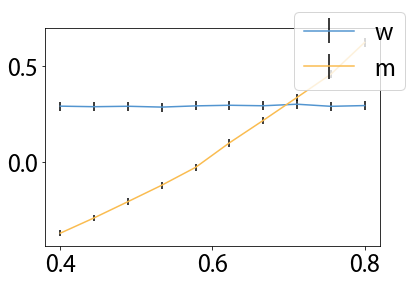

In [33]:
# plot parameter sweep
# static differences over time
statics = [d[1] for d in data]
fig = plt.figure(figsize=(6,4))
w_cite = [x[0]['wmu'] for x in statics]
w_err = [x[0]['wstd'] for x in statics]
m_cite = [x[0]['mmu'] for x in statics]
m_err = [x[0]['mstd'] for x in statics]

plt.errorbar(parameter, w_cite, np.abs(np.concatenate((np.array(w_err).reshape(-1,1), 
                                                -np.array(w_err).reshape(-1,1)), axis=1).T), label='w', 
             color=colors[2], ecolor='black')
plt.errorbar(parameter, m_cite, np.abs(np.concatenate((np.array(m_err).reshape(-1,1), 
                                                -np.array(m_err).reshape(-1,1)), axis=1).T), label='m', 
             color=colors[3], ecolor='black')
fig.legend()
plt.savefig('../data/img/static_ps_walk.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


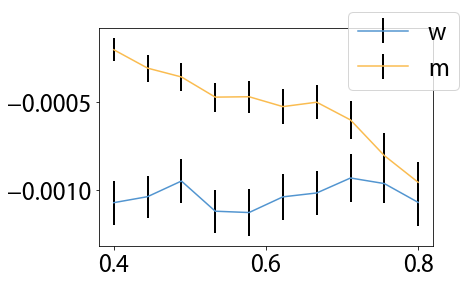

In [34]:
# plot slopes of W cites
slopes = [d[0] for d in data]
fig = plt.figure(figsize=(6,4))
w_slope = [x[0]['wslope'] for x in slopes]
w_err = [x[0]['wci'] for x in slopes]
m_slope = [x[0]['mslope'] for x in slopes]
m_err = [x[0]['mci'] for x in slopes]
w_err = np.array(w_err).T - w_slope
m_err = np.array(m_err).T - m_slope

plt.errorbar(parameter, w_slope, np.abs(w_err), label='w', color=colors[2], ecolor='black', elinewidth=2)
plt.errorbar(parameter, m_slope, np.abs(m_err), label='m', color=colors[3], ecolor='black', elinewidth=2)
fig.legend()
plt.savefig('../data/img/tv_ps_walk.pdf')

### Meet bias - more openness

In [35]:
net_w = (.55,.1)
net_m = (.4,.1)
walk_w = (.55,.05)
walk_m = (.40,.05)
if meet_method == 'soc':
    meet_w = (0.06,0.005)
    meet_m = (0.001,0.00005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)
forget_w = (5.,.02)
forget_m = (9.,.02)

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


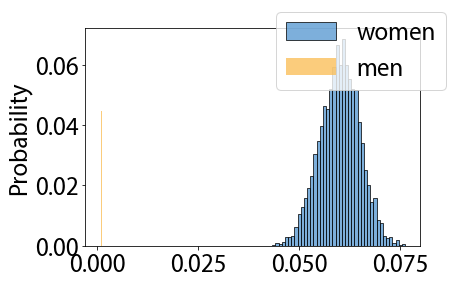

In [36]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/gamma_int3.pdf')

In [37]:
# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
        forget = np.random.normal(loc=forget_m[0],scale=forget_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
        forget = np.random.normal(loc=forget_w[0],scale=forget_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,forget,gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nMeetings))
new_w_perc = ((woman_perc_f*nAuth) - (woman_perc_i*nAuthSt))/(nAuth-nAuthSt) # with probability should the added authors be women?
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nMeetings):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        for j in range(int(dn)):
            f = np.random.rand(1,1)
            a = []
            if f >= new_w_perc:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

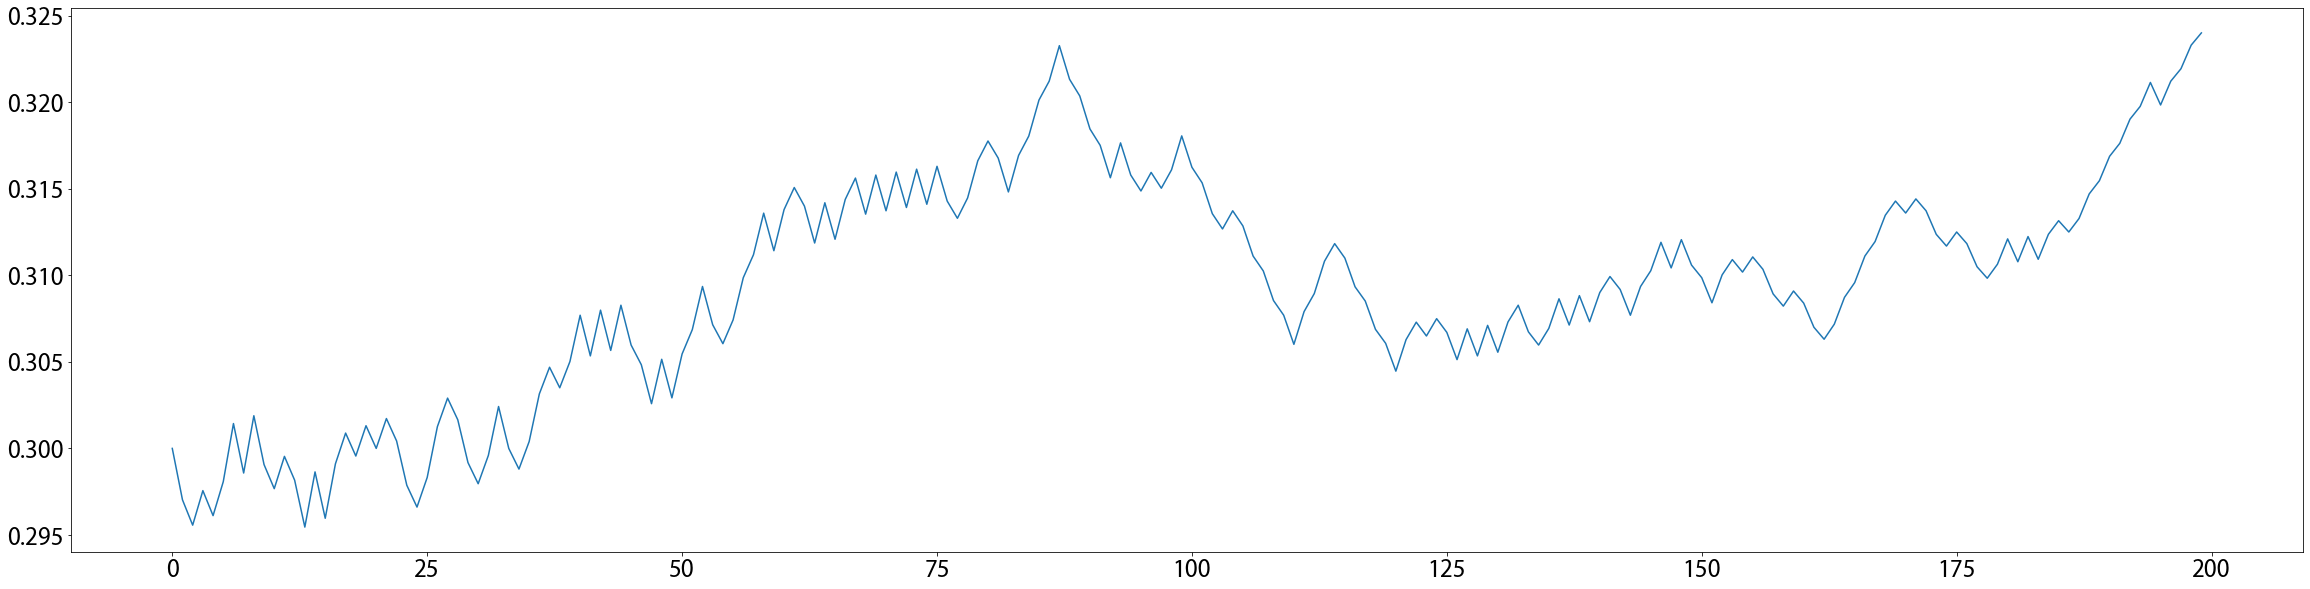

In [38]:
# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in enumerate(range(nMeetings)):
    #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])
    data.append(tmp)
    del tmp

# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms


#### Plots

<AxesSubplot:>

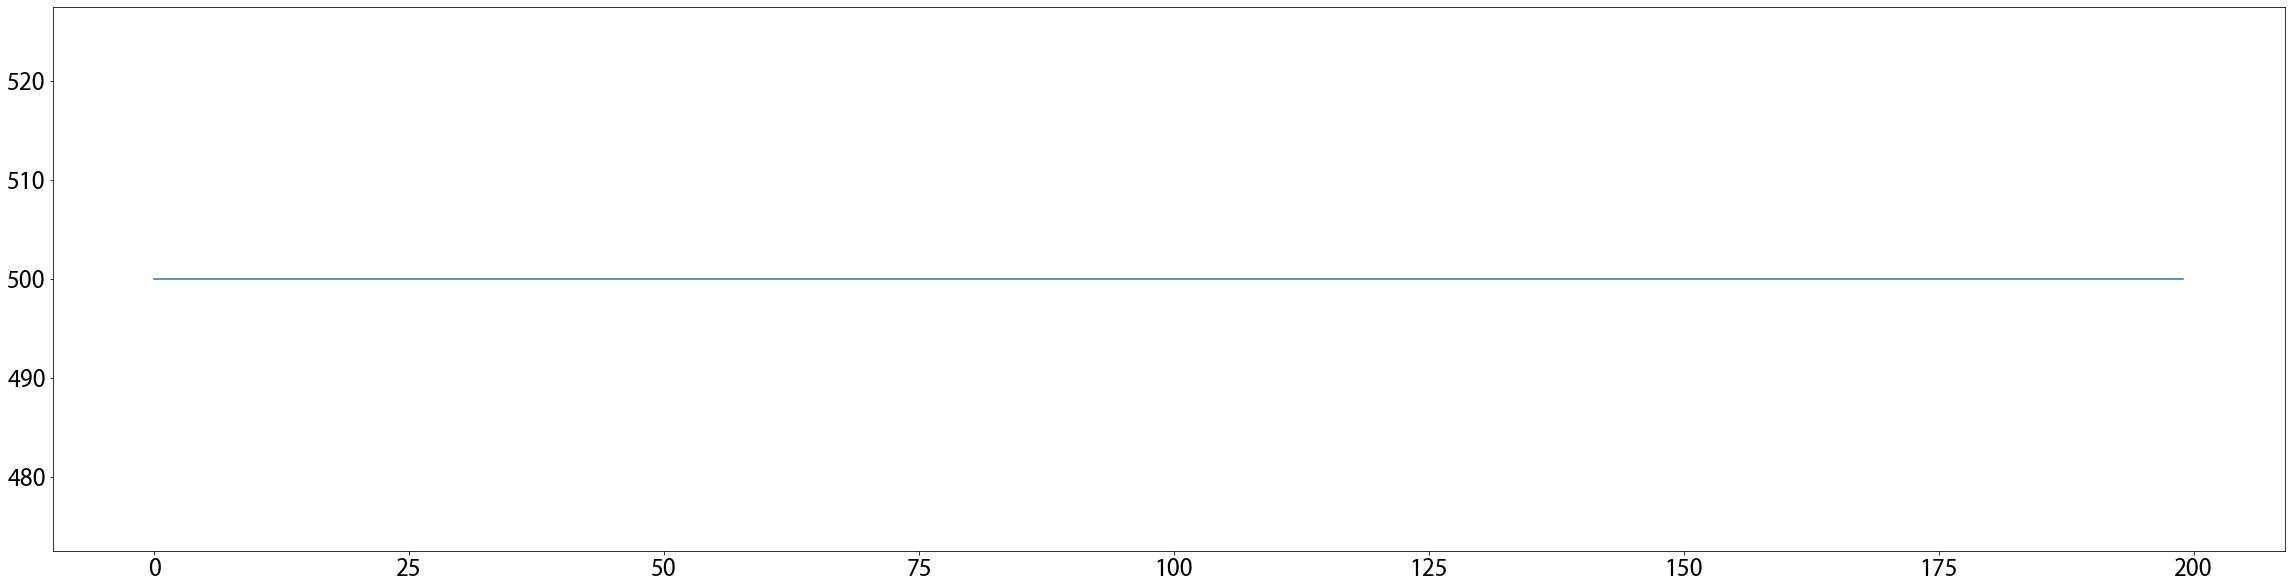

In [39]:
# network size
plt.figure(figsize=(40,10))
sns.lineplot(data=[x[0] for x in net_size])

Text(0.5, 1.0, 'Different Gender Meetings')

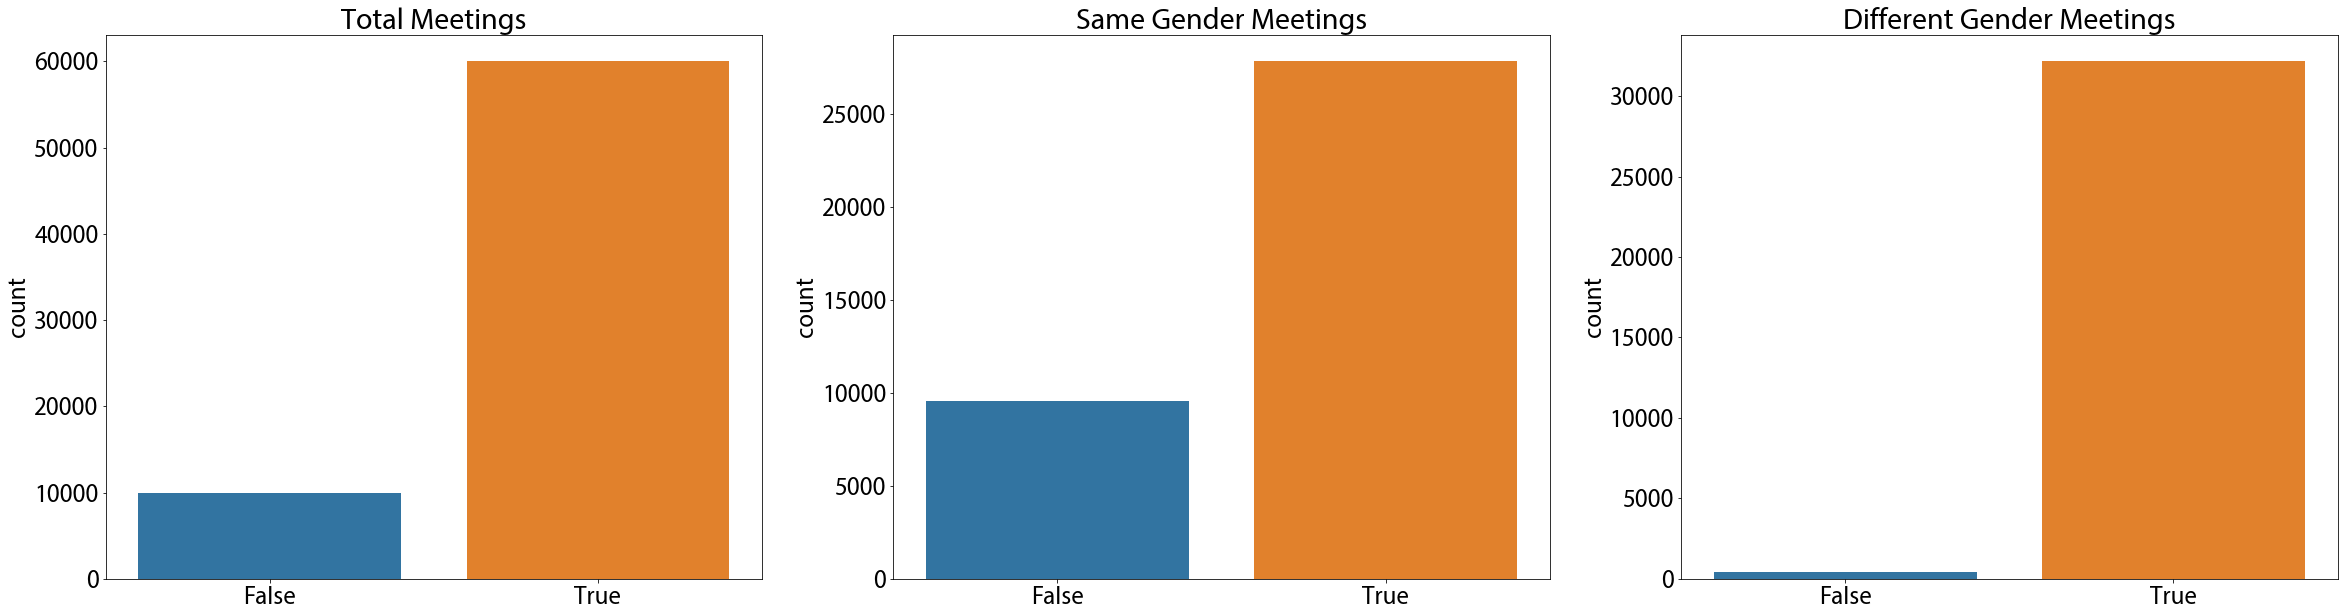

In [40]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


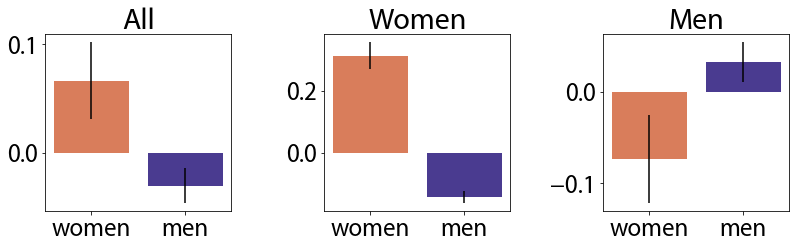

In [41]:
# static plot
static_perc = np.empty((nMeetings,len(bibs[nMeetings-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nMeetings,len(bibs_w[nMeetings-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nMeetings,len(bibs_m[nMeetings-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.bar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])], color=colors)
plt.errorbar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])],
             [np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nMeetings-1])), 
                          np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nMeetings-1]))], fmt='none', color='k')
plt.title('All')
plt.subplot(132)
plt.bar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_w.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])], color=colors)
plt.errorbar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_w.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])],
             [np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs_w[nMeetings-1])), 
                          np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs_w[nMeetings-1]))], fmt='none', color='k')
plt.title('Women')
plt.subplot(133)
plt.bar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_m.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])], color=colors)
plt.errorbar(['women','men'], [np.nanmean([(x-percs)/percs for x in static_perc_m.T]), 
                          np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])],
             [np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs_m[nMeetings-1])), 
                          np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs_m[nMeetings-1]))], fmt='none', color='k')
plt.title('Men')
plt.tight_layout()
plt.savefig('../data/img/static_cites_int3.pdf')

In [42]:
# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

All citers (w): 5.574331937756547, 4.590350150630177e-08
All citers (m): -5.631459348604526, 3.381741287726491e-08
W citers (w): 12.470131827522799, 2.0815710206396674e-25
W citers (m): -12.411174801272193, 3.0326831747825237e-25
M citers (w): -8.533858231781576, 1.7388779653250639e-15
M citers (m): 8.347847666269978, 5.90363428173611e-15


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


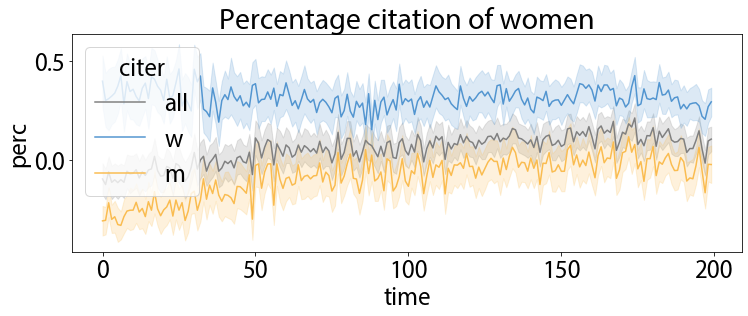

In [43]:
cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig('../data/img/all_cite_w_int3.pdf')

In [44]:
# stats
X = sm.add_constant(range(nMeetings))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

All citers: 0.0010043761925171346, 8.50788865457868e-44
W citers: -0.00012278948931235313, 0.04803286728507893
M citers: 0.0013078963728094402, 1.8071360160248124e-38


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


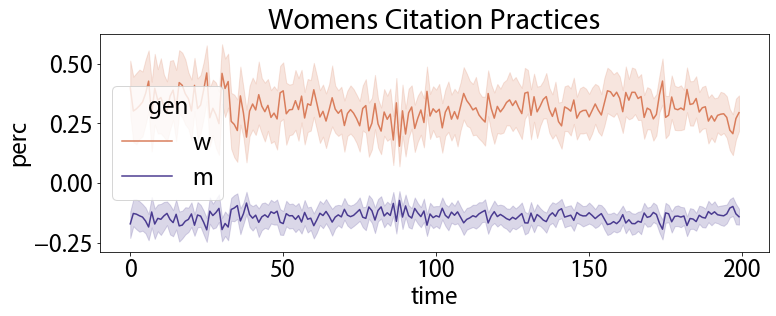

In [45]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'w'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Womens Citation Practices')
plt.savefig('../data/img/w_cite_w_int3.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


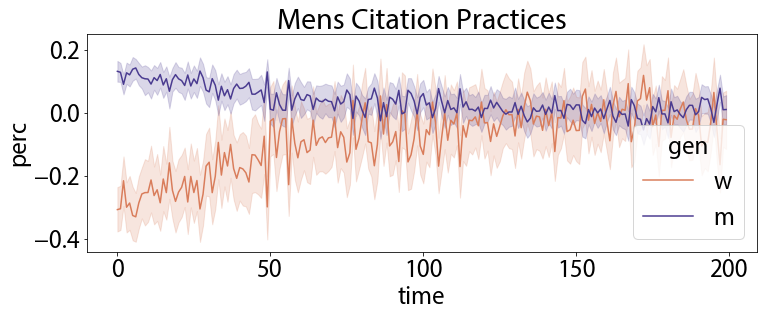

In [46]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'm'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Mens Citation Practices')
plt.savefig('../data/img/m_cite_w_int3.pdf')

#### Parameter sweep

In [47]:
# parameter range we are interested in
parameter = np.linspace(.001,.06,10)
parameter_std = np.linspace(0.00005, 0.005, 10)
parameter_forget = np.array([9., 8.5,  8.5, 8.,  7.5, 7.,  6.5, 6.,  5.5, 5.])
statics = []
slopes = []
net_sizes = []
all_meets = []

# generate authors
authors_orig = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
        forget = np.random.normal(loc=forget_m[0],scale=forget_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
        forget = np.random.normal(loc=forget_w[0],scale=forget_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,forget,gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors_orig.append(a)
    
# simulate meeting parameters
w_index = [a.gender == 'W' for a in authors_orig]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nMeetings))
new_w_perc = ((woman_perc_f*nAuth) - (woman_perc_i*nAuthSt))/(nAuth-nAuthSt) # with probability should the added authors be women?
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nMeetings):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    rem_auths = [j for j,a in enumerate(authors_orig) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors_orig) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors_orig) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        for j in range(int(dn)):
            f = np.random.rand(1,1)
            a = []
            if f >= new_w_perc:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors_orig[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]
        

In [ ]:
        
# loop through the new parameters
data_m = Parallel(n_jobs=4)(
    delayed(param_sweep)(authors_orig, 'meet', p, parameter_std, i)
    for i,p in tqdm(enumerate(parameter)) 
)
    

4it [00:16, 10.73it/s]

In [ ]:
# plot parameter sweep
# static differences over time
statics = [d[1] for d in data_m]
fig = plt.figure(figsize=(6,4))
w_cite = [x[0]['wmu'] for x in statics]
w_err = [x[0]['wstd'] for x in statics]
m_cite = [x[0]['mmu'] for x in statics]
m_err = [x[0]['mstd'] for x in statics]

plt.errorbar(parameter, w_cite, np.abs(np.concatenate((np.array(w_err).reshape(-1,1), 
                                                -np.array(w_err).reshape(-1,1)), axis=1).T), label='w', 
             color=colors[2], ecolor='black')
plt.errorbar(parameter, m_cite, np.abs(np.concatenate((np.array(m_err).reshape(-1,1), 
                                                -np.array(m_err).reshape(-1,1)), axis=1).T), label='m', 
             color=colors[3], ecolor='black')
fig.legend()
plt.savefig('../data/img/static_ps_meet.pdf')

In [ ]:
# plot slopes of W cites
slopes = [d[0] for d in data_m]
fig = plt.figure(figsize=(6,4))
w_slope = [x[0]['wslope'] for x in slopes]
w_err = [x[0]['wci'] for x in slopes]
m_slope = [x[0]['mslope'] for x in slopes]
m_err = [x[0]['mci'] for x in slopes]
w_err = np.array(w_err).T - w_slope
m_err = np.array(m_err).T - m_slope

plt.errorbar(parameter, w_slope, np.abs(w_err), label='w', color=colors[2], ecolor='black', elinewidth=2)
plt.errorbar(parameter, m_slope, np.abs(m_err), label='m', color=colors[3], ecolor='black', elinewidth=2)
fig.legend()
plt.savefig('../data/img/tv_ps_meet.pdf')

### Simulate CDS

In [ ]:
net_w = (.55,.1)
net_m = (.4,.1)
walk_w = (.55,.05)
walk_m = (.50,.05)
if meet_method == 'soc':
    meet_w = (0.06,0.005)
    meet_m = (0.01,0.00005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)
forget_w = (5.,.02)
forget_m = (7.1,.02)